In [ ]:
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import tqdm
import PIL
from matplotlib import pyplot as plt

In [ ]:
prompt = ''

device = 'cuda'
seed = 2024
noisy_sample = torch.randn(
    1, 4, 64, 64
).to(device)
# noisy_sample = torch.randn(
#     1, 4, 512, 512
# ).to('cuda:0')
# noisy_sample = torch.randn(
#     1, 4, 56, 56
# ).to('cuda:0')
# prompt.to(device)

In [ ]:
def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

## 填充腐蚀区域（前提要有members的mask）

### 1.基于members的mask，生成腐蚀（腐蚀形状：多边形；腐蚀数量：自定义，一定范围自动确定；腐蚀尺度：一定范围随机生成）

In [ ]:
def times(x, y):
    return x * y
type(times)

### ！！形状和形状的数量可控，损伤的类型可控（以腐蚀为例）

(512, 512)
145005
170
252
85
255
55
328
136
183
182
147


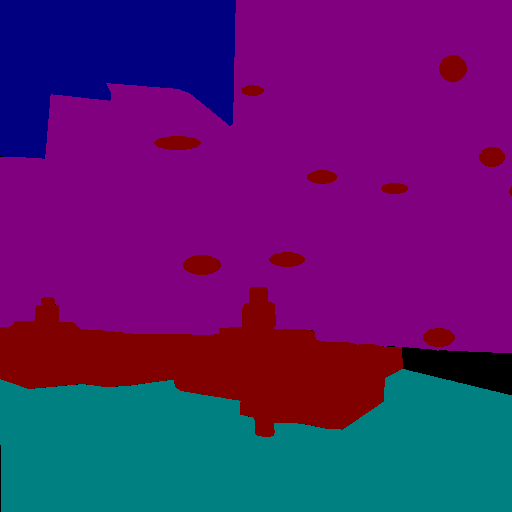

In [ ]:
from PIL import Image, ImageDraw
import random
import numpy as np

mask_members_np_demo = np.array(Image.open(mask_members_dir))
print(mask_members_np_demo.shape)

random.seed(4)

########### 定义颜色转换方法 ##############
import imgviz

def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil



def generate_ellipses(arr, fill_value=1, values=[5], num_ellipses=10, a_min=20, a_max=50, b_min=10, b_max=30):
    """
    🕐用少数量的大椭圆，模拟大片的腐蚀；
    🕑用多数量的小椭圆，模拟pitting corrosion
    Generate random quadrilaterals within the specified regions of a NumPy array
    and fill them with a specified value.

    Args:
        arr (numpy.ndarray): The input array.
        num_polygons (int): The number of quadrilaterals to generate.
        fill_value (int, optional): The value to use for filling the quadrilaterals. Default is 1.
        values (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1].

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing the generated and filled quadrilaterals.
    """
    
    selected_region = np.isin(arr, values)
    # print(selected_region)
    selected_coords = np.argwhere(selected_region)
    print(len(selected_coords))
    # # 椭圆数量和范围
    # num_ellipses = 5
    # a_min, a_max = 20, 50
    # b_min, b_max = 10, 30
    
    result = arr.copy()
    image = Image.fromarray(result)
    draw = ImageDraw.Draw(image)
    
    # 空白mask
    result_blank = np.zeros_like(result)
    # print(result_blank)
    image_blank = Image.fromarray(result_blank)
    draw_blank = ImageDraw.Draw(image_blank)
    # # 生成图片
    # im = Image.new('RGB', (100,100), color='white')  
    # draw = ImageDraw.Draw(im)

    for i in range(num_ellipses):
        xy_arr = random.sample(list(selected_coords), k=1)
        # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
        print(xy_arr[0][0])
        y, x = xy_arr[0][0], xy_arr[0][1]
        # 随机生成长短半轴
        a = random.randint(a_min, a_max)
        b = random.randint(b_min, b_max)
        
        # 随机中心点
        # x = random.randint(0, 100-a)
        # y = random.randint(0, 100-b)
        
        # 绘制椭圆
        draw.ellipse((x, y, x+a, y+b), fill=fill_value)
        draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
    
    result = np.array(image)
    result_mask = np.array(image_blank)
    
    return result, result_mask
    
result_e, result_mask_e = generate_ellipses(arr=mask_members_np_demo)
colored_mask(result_e)

In [ ]:
###################################################################################
# img_name = 'IMG_20230715_152221'
select_area_list = [1]
img_name = '120'
org_img_dir = f'/home/ubunto/Project/konglx/generate/ControlNet-v1-1-nightly/training/corrosion_and_crack/corrosion/JPEGImages/{img_name}.jpg'
org_img_pil = load_image(org_img_dir)
# print(org_img_pil.mode)
mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion/conditioning_images/{img_name}.png'
mask_members_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/members/conditioning_images/{img_name}.png'

# mask_members_dir = None
mask_depth_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth/conditioning_images/{img_name}.png'
###################################################################################

########### 定义颜色转换方法 ##############
import imgviz

def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil


########### 定义基于numpy选择构件的函数#####

def filter_array(arr, values):
    """
    Filter a NumPy array to keep only the specified values.

    Args:
        arr (numpy.ndarray): The input array to be filtered.
        values (list or tuple): A list or tuple of values to keep in the filtered array.

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing only the specified values.
    """
    conditions = [arr == value for value in values]
    condition = np.logical_or.reduce(conditions)
    filtered_arr = np.where(condition, arr, 0)
    return filtered_arr
#########################################

########## 定义生成任意多边形 ##############
import numpy as np
import random
from PIL import Image, ImageDraw

def generate_polygon(arr, num_polygons, fill_value=1, values=[1], polygon_shape=4):
    """
    Generate random quadrilaterals within the specified regions of a NumPy array
    and fill them with a specified value.

    Args:
        arr (numpy.ndarray): The input array.
        num_polygons (int): The number of quadrilaterals to generate.
        fill_value (int, optional): The value to use for filling the quadrilaterals. Default is 1.
        values (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1].

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing the generated and filled quadrilaterals.
    """
    selected_region = np.isin(arr, values)
    selected_coords = np.argwhere(selected_region)

    result = arr.copy()
    image = Image.fromarray(result)
    draw = ImageDraw.Draw(image)
    
    # 空白mask
    result_blank = np.zeros_like(result)
    # print(result_blank)
    image_blank = Image.fromarray(result_blank)
    draw_blank = ImageDraw.Draw(image_blank)

    for _ in range(num_polygons):
        coords = random.sample(list(selected_coords), polygon_shape)
        polygon_coords = [(coord[1], coord[0]) for coord in coords]
        draw.polygon(polygon_coords, fill=fill_value)
        
        draw_blank.polygon(polygon_coords, fill=fill_value)

    result = np.array(image)
    result_mask = np.array(image_blank)
    # plt.imshow(result_mask)
    return result, result_mask
#########################################

###### 定义选定区域内生成若干数量的腐蚀#######
def generate_polygon_to_want_area(org_img_np, generate_polygon, fill_value, want_area = [1,4]):
    """
    generate_polygon_to_want_area based on function 'generate_polygon'.

    Args:
        org_img_np (numpy.ndarray): The input array.
        generate_polygon (function): generate_polygon
        want_area_list (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1,4].

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing the generated and filled polygon.
    """
    list_area_corrosion = []
    list_area_only_corrosion = []
    for area in want_area:
        gen_polygon, gen_polygon_blank = generate_polygon(arr=org_img_np, num_polygons=1, values=[area], fill_value=fill_value, polygon_shape=5)
        list_area_corrosion.append(gen_polygon)
        list_area_only_corrosion.append(gen_polygon_blank)
    sum_area = np.sum(list_area_corrosion, axis=0)
    sum_area_only_corrosion = np.sum(list_area_only_corrosion, axis=0)
    return sum_area, list_area_corrosion, sum_area_only_corrosion, list_area_only_corrosion

mask_corrosion_pil_org = load_image(mask_corrosion_dir)
mask_corrosion_pil_org.mode, np.array(mask_corrosion_pil_org).min(), np.array(mask_corrosion_pil_org).max(), np.array(org_img_pil).min(), np.array(org_img_pil).max(), transforms.ToTensor()(org_img_pil).min(),transforms.ToTensor()(org_img_pil).max(), transforms.ToTensor()(mask_corrosion_pil_org).min(),transforms.ToTensor()(mask_corrosion_pil_org).max()

seed_setting = 7 # 展示用的是seed_setting=16
fill_value_setting = 12 # 以12 为填充数据，与memberstype分开，而后再通过corrosionType_to_fill_value返回对应corrosionType

corrosionType = [3] # 腐蚀类型： 1-fair，2-poor， 3-severe
def corrosionType_to_fill_value(corrosionType):
    fill_value = []
    for i in corrosionType:
        if i==1:
            fill_value.append(12)
        elif i==2:
            fill_value.append(6)
        elif i==3:
            fill_value.append(4)
    return fill_value

fill_value_list = corrosionType_to_fill_value(corrosionType=corrosionType) # 以12为总数量，fill_value与corrosionType对应：腐蚀类型： 1-fair对应12/12，2-poor对应12/6， 3-severe对应12/4


random.seed(seed_setting)  # 7
# 1.members的mask
mask_members_pil_org = Image.open(mask_members_dir)
plt.figure(figsize=(16,7))
plt.subplot(241)
plt.imshow(mask_members_pil_org)
# mask_members_pt_mode_R = transforms.ToTensor()(mask_members_pil_org)  # mode为P的PIL，经过ToTensor转为了[0,1]区间内
# print(transforms.ToTensor()(mask_members_pil_org).unique())
mask_members_np_mode_R = np.array(mask_members_pil_org) # 将PIL转为np，不改变数值
mask_members_pt_mode_R_from_np = torch.from_numpy(mask_members_np_mode_R)
# print(mask_members_pt_mode_R_from_np.min(), mask_members_pt_mode_R_from_np.max(), mask_members_pt_mode_R_from_np.shape)

mask_members_np_mode_R_filter = filter_array(mask_members_np_mode_R, [1,4])
# 2.选择members区域
plt.subplot(242)
plt.imshow(mask_members_np_mode_R_filter)
print(mask_members_np_mode_R_filter.shape, mask_members_np_mode_R_filter.min(), mask_members_np_mode_R_filter.max(), np.unique(mask_members_np_mode_R_filter))
# print(mask_members_np_mode_R[mask_members_np_mode_R==1].reshape(mask_members_np_mode_R.shape[0], mask_members_np_mode_R.shape[1]))
# mask_members_pt_mode_R.min(), mask_members_pt_mode_R.max(), mask_members_np_mode_R.min(), mask_members_np_mode_R.max(), mask_members_np_mode_R.shape
transforms.ToTensor()(mask_members_np_mode_R_filter).max()

# 3.在members区域生成任意数量，任意数值的corrosion的mask （展示用）

mask_members_with_gen_corrosion, mask_members_with_gen_corrosion_blank = generate_polygon(arr=mask_members_np_mode_R_filter, num_polygons=1, values=[4], fill_value=fill_value_setting, polygon_shape=5)
plt.subplot(243)
plt.imshow(mask_members_with_gen_corrosion)

# 4.在members指定区域生成任意数量的腐蚀，返回仅仅为腐蚀区域 （生成用）
mask_corrosion_corr_to_members, mask_corrosion_corr_to_members_list, mask_only_corrosion_corr_to_members, mask_only_corrosion_corr_to_members_list = generate_polygon_to_want_area(org_img_np=mask_members_np_mode_R, generate_polygon=generate_polygon, fill_value=fill_value_setting)
plt.subplot(244)
plt.imshow(mask_corrosion_corr_to_members)
plt.title('Generate corrosion mask with members')

# plt.subplot(245)
# plt.imshow(mask_only_corrosion_corr_to_members)

# print(np.unique(mask_only_corrosion_corr_to_members))
# plt.subplot(246)
# plt.imshow(mask_only_corrosion_corr_to_members/12)

mask_only_corrosion_corr_to_members_devide_by_fill_value = (mask_only_corrosion_corr_to_members/fill_value_list[0]).astype((np.uint64))
plt.subplot(247)
plt.imshow(mask_only_corrosion_corr_to_members_devide_by_fill_value)
print(mask_only_corrosion_corr_to_members_devide_by_fill_value.min(), mask_only_corrosion_corr_to_members_devide_by_fill_value.max(), np.unique(mask_only_corrosion_corr_to_members_devide_by_fill_value), mask_only_corrosion_corr_to_members_devide_by_fill_value.dtype)
# print(np.unique(mask_only_corrosion_corr_to_members/12), mask_only_corrosion_corr_to_members.dtype, ((mask_only_corrosion_corr_to_members/12).astype(np.uint64)).dtype)

mask_only_corrosion_final_pil = colored_mask(mask_only_corrosion_corr_to_members_devide_by_fill_value)
plt.subplot(248)
plt.imshow(mask_only_corrosion_final_pil)
print(mask_only_corrosion_final_pil.mode)
plt.title('Final generate mask')

# 存储
save_mask_dir = f'/home/ubunto/Project/konglx/generate/diffusers/output_imgs/钢构件生成的腐蚀mask/{img_name}__seed_{seed_setting}__corrosionType_{corrosionType[0]}.png'
mask_only_corrosion_final_pil.save(save_mask_dir)

In [ ]:
def paste_pil_a_to_b(a_pil, b_pil):
    a_pil_rgba = a_pil.convert('RGBA')
    b_pil_rgba = b_pil.convert('RGBA')
    a_b_pil_rgba = Image.blend(a_pil_rgba, b_pil_rgba, 0.5)
    a_b_pil_rgb = a_b_pil_rgba.convert('RGB')
    return a_b_pil_rgb

gen_corrosion_with_org_img = paste_pil_a_to_b(org_img_pil, mask_only_corrosion_final_pil)
gen_corrosion_with_org_img

## 载入图片

In [ ]:
# mask_dir = '/home/ubunto/图片/overture-creations-5sI6fQgYIuo_mask.png'
# img_name = '2__1__1848___924'
img_name = '120'
corrosiont_type = corrosionType[0]
print('corrosionType[0]:', corrosionType[0])
# img_name = 'IMG_20230715_152221'
org_img_dir = f'/home/ubunto/Project/konglx/generate/ControlNet-v1-1-nightly/training/corrosion_and_crack/corrosion/JPEGImages/{img_name}.jpg'
org_img_pil = Image.open(org_img_dir)
print(org_img_pil.mode)
# mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion/conditioning_images/{img_name}.png'
# mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/output_imgs/钢构件生成的腐蚀mask/{img_name}__seed_16__corrosionType_{corrosiont_type}.png'
# mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/output_imgs/钢构件生成的腐蚀mask/{img_name}__seed_16__corrosionType_1.png'
# mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/output_imgs/钢构件生成的腐蚀mask/{img_name}__seed_16__corrosionType_2.png'
mask_corrosion_dir = save_mask_dir

mask_members_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/members/conditioning_images/{img_name}.png'
# mask_members_dir = None
mask_depth_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth/conditioning_images/{img_name}.png'
# mask_depth_dir = None

if mask_depth_dir is None:
    # c = 3
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Original image')
    plt.imshow(org_img_pil)
    plt.subplot(132)
    plt.title('Corrosion mask')
    plt.imshow(Image.open(mask_corrosion_dir))
    plt.subplot(133)
    plt.title('Members mask')
    plt.imshow(Image.open(mask_members_dir))
elif mask_members_dir is None:
    # c = 3
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Original image')
    plt.imshow(org_img_pil)
    plt.subplot(132)
    plt.title('Corrosion mask')
    plt.imshow(Image.open(mask_corrosion_dir))
    plt.subplot(133)
    plt.title('Depth mask')
    plt.imshow(Image.open(mask_depth_dir))
else:
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.title('Original image')
    plt.imshow(org_img_pil)
    plt.subplot(142)
    plt.title('Corrosion mask')
    plt.imshow(Image.open(mask_corrosion_dir))
    plt.subplot(143)
    plt.title('Members mask')
    plt.imshow(Image.open(mask_members_dir))
    plt.subplot(144)
    plt.title('Depth mask')
    plt.imshow(Image.open(mask_depth_dir), cmap='gray')
# plt.imshow(Image.open(mask_depth_dir))
# org_img_pil
# mask_corrosion_dir = None
# mask_members_dir = None

# mask_corrosion_pil = load_image(mask_corrosion_dir)
# mask_members_pil = load_image(mask_members_dir)
# print(mask_corrosion_pil.mode, mask_members_pil.mode)
# mask_members_pil
# print(np.array(mask).shape, np.unique(np.array(mask)))
# mask_copy = mask.copy()
# mask_copy_cvt_l = mask_copy.convert("L")
# mask_copy_cvt_l_np = np.array(mask_copy_cvt_l)
# print(mask_copy_cvt_l_np.shape, np.unique(mask_copy_cvt_l_np))
# mask_copy_cvt_l_resized = mask_copy_cvt_l.resize((512, 512))
# print(mask_copy_cvt_l_resized.size)
# mask_copy_cvt_l_t = transforms.ToTensor()(mask_copy_cvt_l_resized).to(device)
# print(mask_copy_cvt_l_t.shape, mask_copy_cvt_l_t.unique())
# mask_copy_cvt_l_resized

In [ ]:
config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5'
control_corrosion_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_inpainting_h-256_w-256_2024-07-12_09:10:44_seeds-2024/checkpoint-5700/controlnet'
control_members_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_members_inpainting_h-256_w-256_2024-07-12_14:52:34_seeds-2024/checkpoint-3800/controlnet'
# control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet'

# controlnet=[controlnet_corrosion,controlnet_members, controlnet_depth]
controlnet_conditioning_scale_list=[1.0,1.0,1.0]

# 有members，无corrosion，无depth
if mask_members_dir is not None and mask_corrosion_dir is None and mask_depth_dir is None:
    mask_members_pil = load_image(mask_members_dir)
    validation_image = mask_members_pil
    control_members_dir = control_members_trained_dir
    print('mask_members_dir is not None and mask_corrosion_dir is None and mask_depth_dir is None')
    controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=controlnet_members).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_members_pil)
    print(mask_members_pil.mode)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
    # Image.show(image)
# 无members，有corrosion，无depth
elif mask_members_dir is  None and mask_corrosion_dir is not None and mask_depth_dir is None:
    control_corrosion_dir = control_corrosion_trained_dir
    mask_corrosion_pil = load_image(mask_corrosion_dir)
    validation_image = mask_corrosion_pil
    print('mask_members_dir is  None and mask_corrosion_dir is not None and mask_depth_dir is None')
    controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=controlnet_corrosion).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
# 无members，无corrosion，有depth  
elif mask_members_dir is  None and mask_corrosion_dir is None and mask_depth_dir is not None:
    # control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
    control_depth_dir = control_depth_trained_dir
    
    mask_depth_pil = load_image(mask_depth_dir)
    validation_image = mask_depth_pil
    print('mask_members_dir is  None and mask_corrosion_dir is None and mask_depth_dir is not None')
    controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=controlnet_depth).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_depth_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
# 有members，有corrosion，无depth
elif mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is None:
    control_corrosion_dir = control_corrosion_trained_dir
    control_members_dir = control_members_trained_dir
    mask_members_pil = load_image(mask_members_dir)
    mask_corrosion_pil = load_image(mask_corrosion_dir)
    validation_image = [mask_corrosion_pil, mask_members_pil]
    print('mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is None')
    controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
    controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion, controlnet_members]).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.imshow(mask_corrosion_pil)
    print(mask_corrosion_pil.mode)
    plt.subplot(142)
    plt.imshow(mask_members_pil)
    print(mask_members_pil.mode)
    plt.subplot(143)
    plt.imshow(org_img_pil)
    plt.subplot(144)
    plt.imshow(image)
    plt.show()
# 无members，有corrosion，有depth 
elif mask_members_dir is  None and mask_corrosion_dir is not None and mask_depth_dir is not None:
    control_corrosion_dir = control_corrosion_trained_dir
    # control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
    control_depth_dir = control_depth_trained_dir
    
    mask_depth_pil = load_image(mask_depth_dir)
    mask_corrosion_pil = load_image(mask_corrosion_dir)
    validation_image = [mask_corrosion_pil, mask_depth_pil]
    print('mask_members_dir is  None and mask_corrosion_dir is not None and mask_depth_dir is not None')
    controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
    controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion, controlnet_depth]).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.imshow(mask_corrosion_pil)
    print(mask_corrosion_pil.mode)
    plt.subplot(142)
    plt.imshow(mask_depth_pil)
    print(mask_depth_pil.mode)
    plt.subplot(143)
    plt.imshow(org_img_pil)
    plt.subplot(144)
    plt.imshow(image)
    plt.show()
# 有members，无corrosion，有depth
elif mask_members_dir is not None and mask_corrosion_dir is None and mask_depth_dir is not None:
    control_members_dir = control_members_trained_dir
    # control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
    control_depth_dir = control_depth_trained_dir
    
    mask_depth_pil = load_image(mask_depth_dir)
    mask_members_pil = load_image(mask_members_dir)
    validation_image = [mask_members_pil, mask_depth_pil]
    print('mask_members_dir is not None and mask_corrosion_dir is None and mask_depth_dir is not None')
    controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
    controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_members, controlnet_depth]).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.imshow(mask_members_pil)
    print(mask_members_pil.mode)
    plt.subplot(142)
    plt.imshow(mask_depth_pil)
    print(mask_depth_pil.mode)
    plt.subplot(143)
    plt.imshow(org_img_pil)
    plt.subplot(144)
    plt.imshow(image)
    plt.show()
# 有members，有corrosion，有depth
elif mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is not None:
    control_corrosion_dir = control_corrosion_trained_dir
    control_members_dir = control_members_trained_dir
    # control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
    control_depth_dir = control_depth_trained_dir
    
    mask_corrosion_pil = load_image(mask_corrosion_dir)
    mask_members_pil = load_image(mask_members_dir)
    mask_depth_pil = load_image(mask_depth_dir)
    validation_image = [mask_corrosion_pil, mask_members_pil, mask_depth_pil]
    print('mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is not None')
    controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
    controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
    controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion,controlnet_members, controlnet_depth], controlnet_conditioning_scale=controlnet_conditioning_scale_list).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(20, 5))
    plt.subplot(151)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(152)
    plt.imshow(mask_members_pil)
    print(mask_members_pil.mode)
    plt.subplot(153)
    plt.imshow(mask_depth_pil)
    print(mask_depth_pil.mode)
    plt.subplot(154)
    plt.imshow(org_img_pil)
    plt.subplot(155)
    plt.imshow(image)
    plt.show()
# 无members，无corrosion，无depth
else:
    print('Input nothing')
# image

In [ ]:
mask_corrosion_np = np.array(mask_corrosion_pil)
mask_corrosion_np.min(), mask_corrosion_np.max(), mask_corrosion_np.shape

In [ ]:
# if mask_members_dir is not None and mask_corrosion_dir is None:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(121)
#     plt.imshow(mask_members_pil)
#     plt.subplot(122)
#     plt.imshow(image)
#     plt.show()
#     # Image.show(image)
    
# elif mask_members_dir is  None and mask_corrosion_dir is not None:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(121)
#     plt.imshow(mask_corrosion_pil)
#     plt.subplot(122)
#     plt.imshow(image)
#     plt.show()
# else:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(131)
#     plt.imshow(mask_corrosion_pil)
#     plt.subplot(132)
#     plt.imshow(mask_members_pil)
#     plt.subplot(133)
#     plt.imshow(image)
#     plt.show()

## PNDM

In [ ]:
# PNDMScheduler
generator = torch.Generator(device=device).manual_seed(seed)
image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

## DDPM

In [ ]:
# DDPMScheduler
from diffusers import DDPMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_ddpm = DDPMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

# print(pipeline.scheduler)
pipeline.scheduler = scheduler_ddpm
# print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

In [ ]:
if mask_members_dir is not None and mask_corrosion_dir is None:

    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_members_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
    # Image.show(image)
    
elif mask_members_dir is  None and mask_corrosion_dir is not None:

    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
else:

    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(142)
    plt.imshow(mask_members_pil)
    plt.subplot(143)
    plt.imshow(org_img_pil)
    plt.subplot(144)
    plt.imshow(image)
    plt.show()

## DDIM

In [ ]:
# DDIMScheduler
from diffusers import DDIMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_ddim = DDIMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

print(pipeline.scheduler)
pipeline.scheduler = scheduler_ddim
print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

## PNDM

In [ ]:
# PNDMScheduler
from diffusers import PNDMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_pndm = PNDMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

print(pipeline.scheduler)
pipeline.scheduler = scheduler_pndm
print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

# ***##step by step denoise##***

In [ ]:

control_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_crack_only_generate/checkpoint-2000/controlnet'
config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5'

## 1.创建各个部分的模型

In [ ]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, ControlNetModel
import os

vae = AutoencoderKL.from_pretrained(config_dir, subfolder='vae', use_safetensors=None)
tokenizer = CLIPTokenizer.from_pretrained(config_dir, subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained(config_dir, subfolder='text_encoder', use_safetensors=None)
unet = UNet2DConditionModel.from_pretrained(config_dir, subfolder='unet', use_safetensors=None)

controlnet = ControlNetModel.from_pretrained(control_dir)
controlnet.config

In [ ]:
vae.config.scaling_factor

In [ ]:
from diffusers import UniPCMultistepScheduler

scheduler_multistep = UniPCMultistepScheduler.from_pretrained(config_dir, subfolder="scheduler")
scheduler_multistep

In [ ]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
controlnet.to(torch_device)
unet.config

## 2.Create embeddings

### 2.1 Create text embeddings

In [ ]:
prompt = ["crack"]
device = 'cuda'
seed = 0
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.Generator(device=device).manual_seed(seed)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [ ]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

prompt_embeds = text_embeddings
encoder_hidden_states_control = text_embeddings
text_embeddings.shape

### 2.2 Create image embeddings

In [ ]:
from torchvision import transforms

mask_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/crack（复件）/SegmentationClass/DeepCrack_11240-6.png'
validation_image = Image.open(mask_dir).convert("RGB")
validation_image.size

conditioning_image_transforms = transforms.Compose(
        [
            transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(512),
            transforms.ToTensor(),
        ]
    )


conditioning_image_pil = validation_image.resize([512, 512])
conditioning_pixel_values = torch.stack([conditioning_image_transforms(conditioning_image_pil)])
conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()
print(conditioning_pixel_values.shape)
controlnet_image = conditioning_pixel_values.to(torch_device)
# print(controlnet_image)
conditioning_image_pil

In [ ]:
'''
You’ll also need to generate the unconditional text embeddings which are the embeddings for the padding token.
These need to have the same shape (batch_size and seq_length) as the conditional text_embeddings:
'''
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
uncond_embeddings.shape, text_embeddings.shape

In [ ]:
# Let’s concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
# text_embeddings
text_embeddings.shape

## 3.Create random noise

In [ ]:
''' 
Next, generate some initial random noise as a starting point for the diffusion process. 
This is the latent representation of the image, and it’ll be gradually denoised. 
At this point, the latent image is smaller than the final image size but that’s okay though 
because the model will transform it into the final 512x512 image dimensions later.
'''

# The height and width are divided by 8 because the vae model has 3 down-sampling layers.
# You can check by running the following:   2 ** (len(vae.config.block_out_channels) - 1) == 8

do_classifier_free_guidance = False
guess_mode = False

latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)



latents.shape

In [ ]:
down_block_res_samples, mid_block_res_sample = controlnet(
                    latents,
                    2,
                    encoder_hidden_states=encoder_hidden_states_control,
                    controlnet_cond=controlnet_image,
                    return_dict=False,
                )
len(down_block_res_samples), down_block_res_samples[-1].shape, len(mid_block_res_sample), mid_block_res_sample[0].shape

## 4.Denoise the image

In [ ]:
'''
Start by scaling the input with the initial noise distribution, sigma, the noise scale value, 
which is required for improved schedulers like UniPCMultistepScheduler: 
'''
print(scheduler_multistep.init_noise_sigma)
latents = latents * scheduler_multistep.init_noise_sigma
latents.shape

In [ ]:
''' 
The last step is to create the denoising loop that’ll progressively 
transform the pure noise in latents to an image described by your prompt.
Remember, the denoising loop needs to do three things:

1.Set the scheduler’s timesteps to use during denoising.
2.Iterate over the timesteps.
3.At each timestep, call the UNet model to predict the noise residual and 
pass it to the scheduler to compute the previous noisy sample.

'''

from tqdm.auto import tqdm

scheduler_multistep.set_timesteps(num_inference_steps)

for t in tqdm(scheduler_multistep.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler_multistep.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler_multistep.step(noise_pred, t, latents).prev_sample

In [ ]:
from PIL import Image
from torchvision import transforms

pil_latents = transforms.ToPILImage()(latents.squeeze(0))
pil_latents


## 5.Decode the image

In [ ]:
# scale and decode the image latents with vae
latents_scaled = 1 / vae.config.scaling_factor * latents
# pil_latents_scaled = transforms.ToPILImage()(latents.squeeze(0))
# pil_latents_scaled = transforms.ToPILImage()(latents_scaled.squeeze(0))
with torch.no_grad():
    # image = vae.decode(latents).sample
    image = vae.decode(latents_scaled).sample
print(image.shape)



In [ ]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

In [ ]:
''' 
The last step is to create the denoising loop that’ll progressively 
transform the pure noise in latents to an image described by your prompt.
Remember, the denoising loop needs to do three things:

1.Set the scheduler’s timesteps to use during denoising.
2.Iterate over the timesteps.
3.At each timestep, call the UNet model to predict the noise residual and 
pass it to the scheduler to compute the previous noisy sample.

'''

from tqdm.auto import tqdm

scheduler_multistep.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    # expand the latents if we are doing classifier free guidance
    latent_model_input_control = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    # latent_model_input_control = torch.cat([latents_control] * 2)

    latent_model_input_control = scheduler.scale_model_input(latent_model_input_control, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred_control = unet(latent_model_input_control, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond_control, noise_pred_text_control = noise_pred_control.chunk(2)
    noise_pred_control = noise_pred_uncond_control+ guidance_scale * (noise_pred_text_control - noise_pred_uncond_control)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred_control, t, latents).prev_sample

In [ ]:
a = any
a in 'abc'